### Using Median Absolute Deviation to Measure Impact of Demographic Features

In [3]:
# First set everthing up
import pyodbc
import graphlab as gl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import local # server information and credentials
import statsmodels.robust.scale as sm # for median absolute deviation (MAD)
import seaborn as sns
from pullODBC import pullODBC
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 10
plt.tight_layout;
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
pd.options.display.float_format = '{:.3f}'.format # display as floating point to 3 decimal places

C:\Anaconda\envs\gl-env\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # for a wide screen

First retrieve the coefficient dataframe and the full demographics dataframe from their pickle files

In [5]:
coeff_df = pd.read_pickle('coeff_df')
demographics = pd.read_pickle('demographics')

Next, create a new dataframe for coefficient statistics, calculate these statistics for categorical variables, and add these to the dataframe

In [6]:
coeff_df['value'].astype('float64') # Ensure that values are float64
coeff_statistics_df = pd.DataFrame(data=None, index=None, columns=['COEF','MIN', 'MAX', 'RANGE', 'MAD'], 
                                 dtype='float64', copy=False) # Create an empty dataframe for statistics
names = coeff_df['name'].unique() # names has all the feature values 
# Iterate through all the features with more than 1 coeffient value (the categorical varaiabes) 
# and add statistics about the coefficient values to coeff_statistics_df
for coeff in names:
    df = coeff_df[coeff_df['name']== coeff]
    if len(df) > 1:
        new_row = pd.DataFrame([[coeff, df['value'].min(), df['value'].max(), df['value'].ptp(), 
                                 sm.mad(df['value'])]], columns=['COEF','MIN', 'MAX', 'RANGE', 'MAD']) 
                               
        coeff_statistics_df = coeff_statistics_df.append(new_row, ignore_index=False)
        
coeff_statistics_df.sort_values('MAD', axis=0, ascending=False, inplace=True, 
                              kind='quicksort', na_position='last') # sort the dataframe on Median Absolute Deviation

In [7]:
print coeff_statistics_df # print the sorted statistics for the categorical variables

               COEF    MIN    MAX  RANGE   MAD
0          zip_code -2.709  1.469  4.178 0.541
0    race_ethnicity -1.613  0.656  2.269 0.388
0       race_gender -1.651  0.523  2.175 0.347
0       birth_state -0.265  0.571  0.836 0.167
0  gender_ethnicity -0.522  0.044  0.567 0.161
0       drivers_lic -0.251 -0.091  0.161 0.119


Now let's work on continuous features

First, extract all the relevant coefficients

In [8]:
#coeff_df = coeff_df.to_dataframe()
birth_age = coeff_df[coeff_df['name']=='birth_age']['value'].iloc[0]
age_squared=coeff_df[coeff_df['name']=='age_squared']['value'].iloc[0]
age_cubed=coeff_df[coeff_df['name']=='age_cubed']['value'].iloc[0]
years_since_registration = coeff_df[coeff_df['name']=='years_since_registration']['value'].iloc[0]
years_squared = coeff_df[coeff_df['name']=='years_squared']['value'].iloc[0]
years_cubed = coeff_df[coeff_df['name']=='years_cubed']['value'].iloc[0]

Create a new row containing statistics on years since registration

In [9]:
years_formula = 'years_since_registration*x + years_squared*x**2 + years_cubed*x**3'
x = np.array(range(0,60))
y = eval(years_formula)
y = pd.Series(y)
new_row_years = pd.DataFrame([['years_since_reg', y.min(), y.max(), y.ptp(), sm.mad(y)]],
                              columns=['COEF','MIN', 'MAX', 'RANGE', 'MAD'])
print new_row_years

              COEF    MIN   MAX  RANGE   MAD
0  years_since_reg -0.882 0.022  0.903 0.344


Create a new row containing statistics on age

In [10]:
years_formula = 'birth_age*x + age_squared*x**2 + age_cubed*x**3'
x = np.array(range(18,81))
y = eval(years_formula)
y = pd.Series(y)
new_row_age = pd.DataFrame([['birth_age', y.min(), y.max(), y.ptp(), sm.mad(y)]],
                              columns=['COEF','MIN', 'MAX', 'RANGE', 'MAD'])
print new_row_age

        COEF    MIN   MAX  RANGE   MAD
0  birth_age -0.255 0.077  0.331 0.086


Add the rows with statistics on age and years since registration to the dataframe, sort by MAD, and print

In [11]:
coeff_statistics_df = coeff_statistics_df.append(new_row_years, ignore_index=False)
coeff_statistics_df = coeff_statistics_df.append(new_row_age, ignore_index=False)
coeff_statistics_df.sort_values('MAD', axis=0, ascending=False, inplace=True, 
                              kind='quicksort', na_position='last')

Final Analysis of Demographic Features' Influence on Party Sentiment Sorted by Median Absolute Deviation

In [12]:
print coeff_statistics_df

               COEF    MIN    MAX  RANGE   MAD
0          zip_code -2.709  1.469  4.178 0.541
0    race_ethnicity -1.613  0.656  2.269 0.388
0       race_gender -1.651  0.523  2.175 0.347
0   years_since_reg -0.882  0.022  0.903 0.344
0       birth_state -0.265  0.571  0.836 0.167
0  gender_ethnicity -0.522  0.044  0.567 0.161
0       drivers_lic -0.251 -0.091  0.161 0.119
0         birth_age -0.255  0.077  0.331 0.086


### Exploring the Distribution of the Probability of Leaning Republican

Plot histograms with rug both with and without kernel density.  

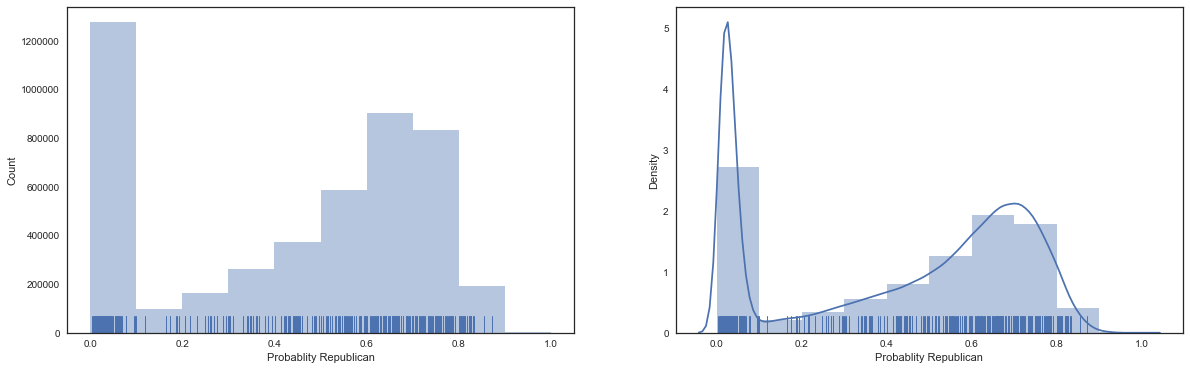

In [13]:
fig, axs = plt.subplots(figsize=(20,6), ncols=2, nrows=1)
# Without Kernel Density
hist = sns.distplot(demographics['percent'],bins=np.arange(0, 1.1, 0.1),norm_hist=False, vertical=False, kde=False, ax=axs[0])
sample = demographics['percent'].sample(frac=0.00009)
rug = sns.rugplot(sample, ax=axs[0])
# With Kernel Density
hist = sns.distplot(demographics['percent'],bins=np.arange(0, 1.1, 0.1),norm_hist=False, vertical=False, kde=True, ax=axs[1])
rug = sns.rugplot(sample, ax=axs[1])
# Labels
axs[0].set_xlabel('Probablity Republican')
axs[0].set_ylabel('Count')
axs[1].set_xlabel('Probablity Republican')
axs[1].set_ylabel('Density')

### Characterizing the demographics of voters with probability republican <= 0.1

In [14]:
low_prob_df = demographics[demographics['percent']<= 0.1]
low_prob_df.columns

Index([u'birth_age', u'party_cd', u'zip_code', u'birth_state', u'drivers_lic',
       u'race_gender', u'race_ethnicity', u'gender_ethnicity', u'age_squared',
       u'age_cubed', u'years_since_registration', u'years_squared',
       u'years_cubed', u'percent'],
      dtype='object')

In [15]:
analysis = low_prob_df.groupby(['race_gender'])['race_gender'].count()/low_prob_df.groupby(['race_gender'])['race_gender'].count().sum()
pd.options.display.float_format = '{:.1%}'.format #display as percentages

In [16]:
print analysis.sort_values(ascending = False)

race_gender
BF   57.3%
BM   40.2%
BU    1.0%
IF    0.3%
MF    0.3%
OF    0.2%
UF    0.2%
WF    0.1%
IM    0.1%
OM    0.1%
UM    0.1%
AF    0.1%
MM    0.0%
UU    0.0%
AM    0.0%
WM    0.0%
AU    0.0%
MU    0.0%
OU    0.0%
WU    0.0%
Name: race_gender, dtype: float64


Conclusion:  98.5% of voters with probability of having Republican sentiment <= 0.1 are African American